In [ ]:
!pip install nilearn

#librairies générales
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps

# librairies machine learning
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing  

#imagerie cIRM
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
import gif_your_nifti.core as gif2nif


  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-l234neho
  Running command git clone -q https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-l234neho


# Visualisation d'images et compréhension du sujet
Cette partie s'intéressera à des images d'exemple où l'on essaiera de manipuler les différentes slices des images 3D d'IRM et où l'on essaiera de voir les différences entre différents types d'IRM (t1, t2, t1ce et les masques de vérité terrain .seg) Ainsi qu'à la définition de nos chemins pour le phases suivantes de training et de validation.

Comme on l'apprends sur ce document de recherche provenant de BratS : https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6975210 ,
Les pixels seront donc classés selon leur classe d'appartenance allant de 1 à 4 pour respectivement l'oedème "OEDEME", le "non enhancing", le "enhancing" et la phase de necrose.

Le dataset provient de http://braintumorsegmentation.org

L'idée est d'ici de proposer une segmentation multi-classe proposant une couleur de masque différente pour chaque classe d'appartenance.

In [ ]:
#Connexion au Drive pour le dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Nombre de slices par image = 150
VOL_SLICES = 100
VOL_START = 30

#Définition des aires de segmentations expliquées plus tôt
SEGMENT_CLASSES = {0 : 'Sain', 1 : 'Nécrotique',  2 : 'Oedème', 3 : 'Evolutif'}

#Chemin vers les dataset de training et de validation 
TRAINING_PATH = '/content/drive/MyDrive/BRATS2021/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021'
VALIDATION_PATH = '/content/drive/MyDrive/BRATS2021/RSNA_ASNR_MICCAI_BraTS2021_ValidationData'

Text(0.5, 1.0, 'Mask')

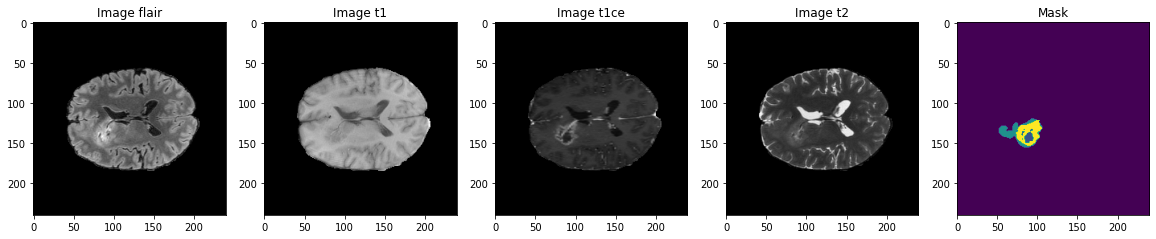

In [ ]:
#Images segmentées manuellement avec des annotations validées par des experts.
image_flair=nib.load(TRAINING_PATH + '/BraTS2021_00000/BraTS2021_00000_flair.nii').get_fdata()
image_t1=nib.load(TRAINING_PATH +'/BraTS2021_00000/BraTS2021_00000_t1.nii.gz').get_fdata()
image_t1ce=nib.load(TRAINING_PATH +'/BraTS2021_00000/BraTS2021_00000_t1ce.nii.gz').get_fdata()
image_t2=nib.load(TRAINING_PATH +'/BraTS2021_00000/BraTS2021_00000_t2.nii.gz').get_fdata()
image_mask=nib.load(TRAINING_PATH +'/BraTS2021_00000/BraTS2021_00000_seg.nii.gz').get_fdata()

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slicewidth = 35
ax1.imshow(image_flair[:,:,image_flair.shape[0]//2-slicewidth], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(image_t1[:,:,image_t1.shape[0]//2-slicewidth], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(image_t1ce[:,:,image_t1ce.shape[0]//2-slicewidth], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(image_t2[:,:,image_t2.shape[0]//2-slicewidth], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(image_mask[:,:,image_mask.shape[0]//2-slicewidth])
ax5.set_title('Mask')

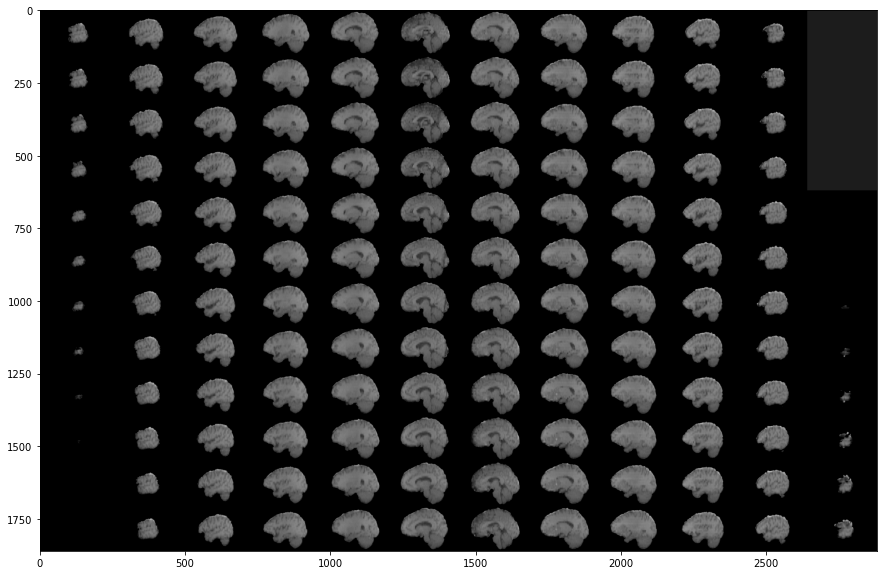

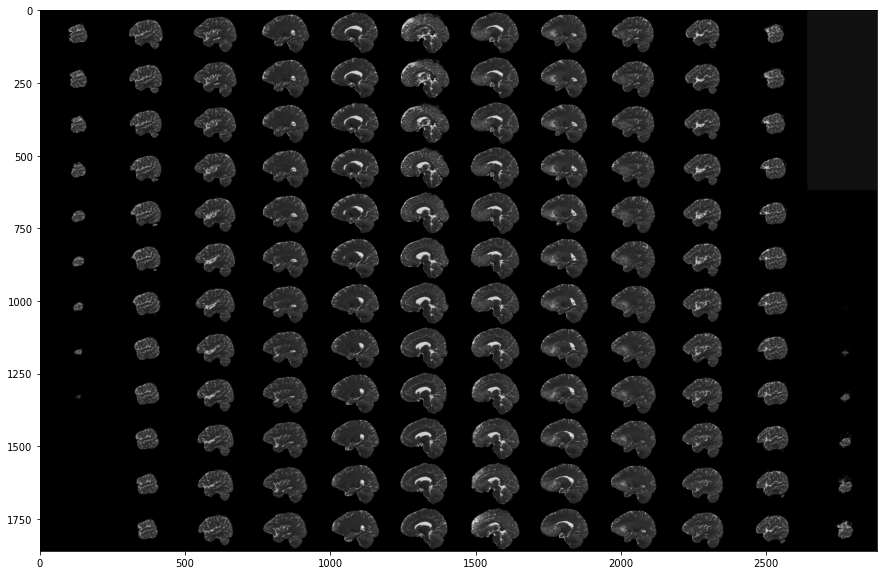

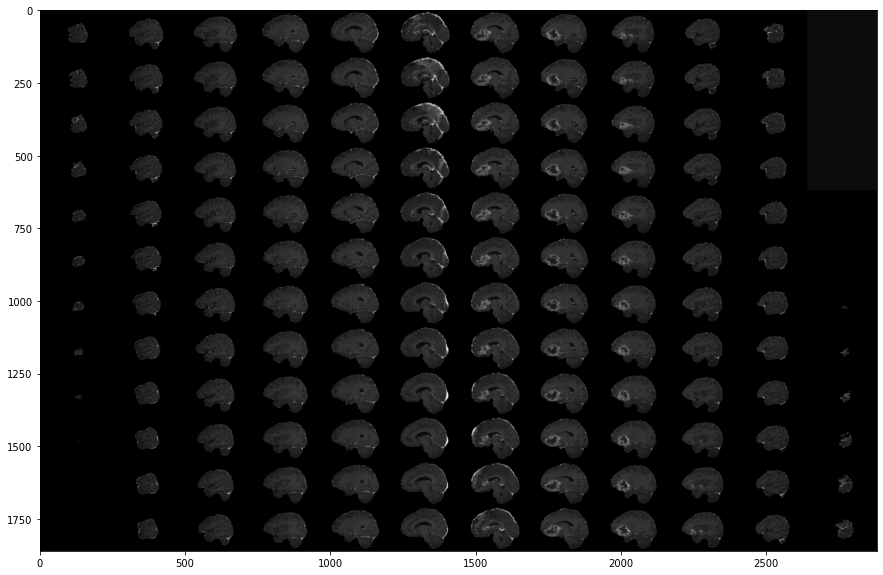

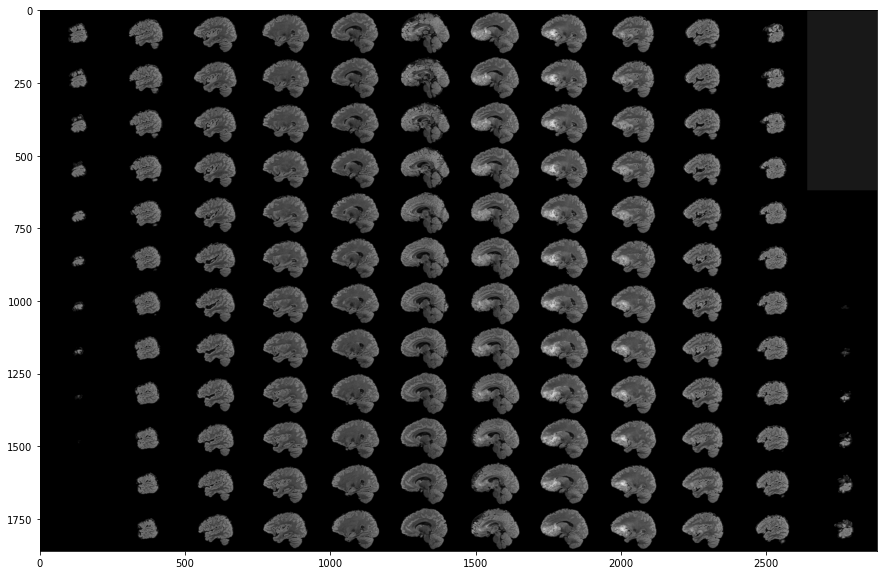

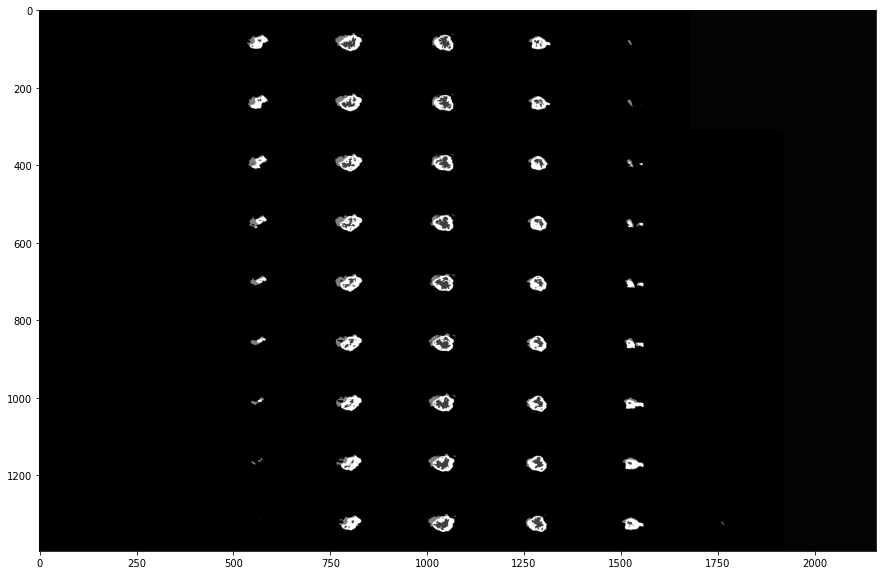

In [ ]:
#Visualisation
#Exemple de vision 3D d'un FLAIR et d'une lésion en affichan chaque "slice" du fichier flair nifti.

#On se débarasse des 50 premieres et dernières images car manque de contenu
#Image d'IRM T1
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

#Images T2 sur lesquelles ont visualise mieux la tumeur. (la graisse parait plus sombre que l'eau)
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(image_t2[50:-50,:,:]), 90, resize=True), cmap ='gray')

fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(image_t1ce[50:-50,:,:]), 90, resize=True), cmap ='gray')

#L'image flair donne des résultats encourageants à première vue
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(image_flair[50:-50,:,:]), 90, resize=True), cmap ='gray')

#De la même façon, on se débarasse des 100 première et 70 dernières images car inutiles.
#Image de masques de vérité terrain
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(image_mask[100:-70,:,:]), 90, resize=True), cmap ='gray')

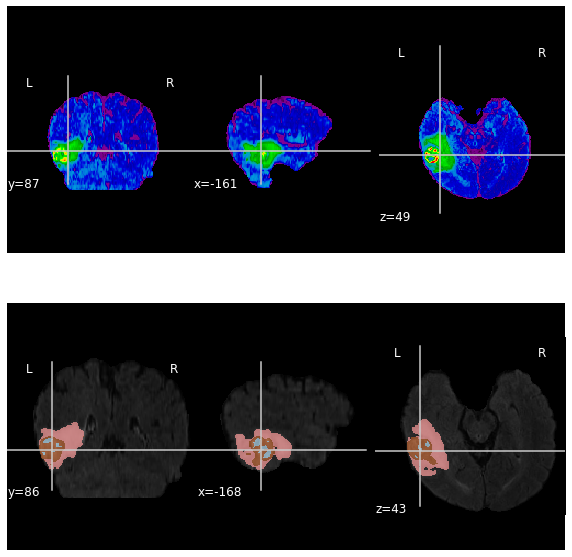

In [ ]:
#Exemple of Axial, Sagittal, Coronal images 
niimg = nl.image.load_img(TRAINING_PATH + '/BraTS2021_00157/BraTS2021_00157_flair.nii.gz')
nimask = nl.image.load_img(TRAINING_PATH + '/BraTS2021_00157/BraTS2021_00157_seg.nii.gz')

fig, axes = plt.subplots(nrows=2, figsize=(10, 10))

#Visualitation des tumeurs grâce à deux techniques différentes.

nlplt.plot_epi(niimg,
               title='',
               axes=axes[0])

#Visualisation de la région d'intérêt avec l'image de base en background
nlplt.plot_roi(nimask, 
               title='',
               bg_img=niimg, 
               axes=axes[1], cmap='Paired')

plt.show()

# Creation du modèle U-NET pour la segmantation

La plupart des réseaux de neurones sont utilisés pour des tâches de classification. Ici, en plus de ceci, nous voulons de la localisation c'est pourquoi nous nous intéressons à une architecture U-NET (https://arxiv.org/abs/1505.04597) typiquement créee pour des tâches de segmentation biomédicales. Une classe pour chaque pixel.



reference pour la compréhension et la conception du modèle u-net : 

*   https://www.jeremyjordan.me/semantic-segmentation/
*   https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a



In [ ]:
#Calcul des données qui iront dans le log de score pour faciliter le calcul lors de la validation.
#Calcul de la Dice loss grâce aux VP, FP, FN.
#Calcul de la precision, sensibilité et spécificité
IMG_SIZE=128
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i]) #faux négatifs
        y_pred_f = K.flatten(y_pred[:,:,:,i]) #faux positifs
        intersection = K.sum(y_true_f * y_pred_f) #intersection
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)) #formule Dice loss
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


#Evaluation du coefficient DICE par classe
#1
def dice_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)
#2
def dice_oedemee(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)
#3
def dice_evolutif(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)


# Calcul de la précision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Calcul de la  sensibilité      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Calcul de la spécificité 
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_necrotic, dice_oedeme ,dice_evolutif] )

In [ ]:
#Lise des dossiers de training et validation
train_folder = [f.path for f in os.scandir('/content/drive/MyDrive/BRATS2021/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021') if f.is_dir()]
val_folder = [f.path for f in os.scandir('/content/drive/MyDrive/BRATS2021/RSNA_ASNR_MICCAI_BraTS2021_ValidationData') if f.is_dir()]

#on efface Fichiers posant problème
#train_and_val_directories.remove(TRAINING_PATH+'/BraTS2021_00716')
#train_and_val_directories.remove(TRAINING_PATH+'/BraTS2021_01028')

#Fait du folder d'images une liste d'ids pour les mettre dans les sets (training test et validation)
def addId(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x
    
#train_and_test_ids = addId(train_and_val_directories);
training_ids = addId(train_folder);
validation_ids =  addId(val_folder);

#division du dataset en train, test et val TEST = 20% du train.
train_ids, test_ids = train_test_split(training_ids,test_size=0.20)

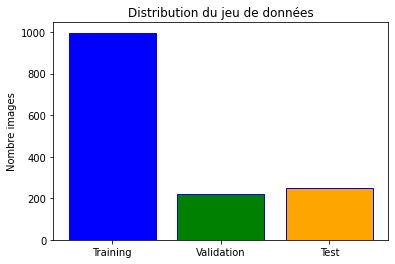

In [ ]:
#Distribution des données
plt.bar(["Training","Validation","Test"],
[len(train_ids), len(validation_ids), len(test_ids)], align='center',color=[ 'blue','green', 'orange'], edgecolor = 'blue')
plt.ylabel('Nombre images')
plt.title('Distribution du jeu de données')

plt.show() 

# Data Generators
Le dataset utilisé dans ce projet est très large et donc, très demandeur en mémoire. Pour contourner ce problème, on utilisera un data generator qui chargera l'entièreté des données de notre dataset et nourrira notre modèle au compte goutte.

source = https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [ ]:

class DataGenerator(tf.keras.utils.Sequence):
    #Generation de données pour keras
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        #Nombre de paquets fournis par epoch
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        #Generation d'un lot 'batch' de data
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        #Liste des ids
        Batch_ids = [self.list_IDs[k] for k in indexes]

        #Generation de données
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size*VOL_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOL_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOL_SLICES, *self.dim, 4))

        
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAINING_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOL_SLICES):
                 X[j +VOL_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOL_START], (IMG_SIZE, IMG_SIZE));
                 X[j +VOL_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOL_START], (IMG_SIZE, IMG_SIZE));

                 y[j +VOL_SLICES*c] = seg[:,:,j+VOL_START];
                    
        #Generation de masques
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_data = DataGenerator(training_ids)
valid_data = DataGenerator(validation_ids)
test_data = DataGenerator(test_ids)

# Evolution des différents scores sur le modèle pré-entraîné
Ici, nous nous intéresserons à l'evolution au fur et à mesure des epochs des performances du modèle. Toutes les fonctions définies plus haut prennent leur sens maintenant, avec le dice (préféré au IoU) général, celui des trois classes, ainsi que les mesures de base de precision (pourcentage de bonnes prédictions), specificité et sensibilité.

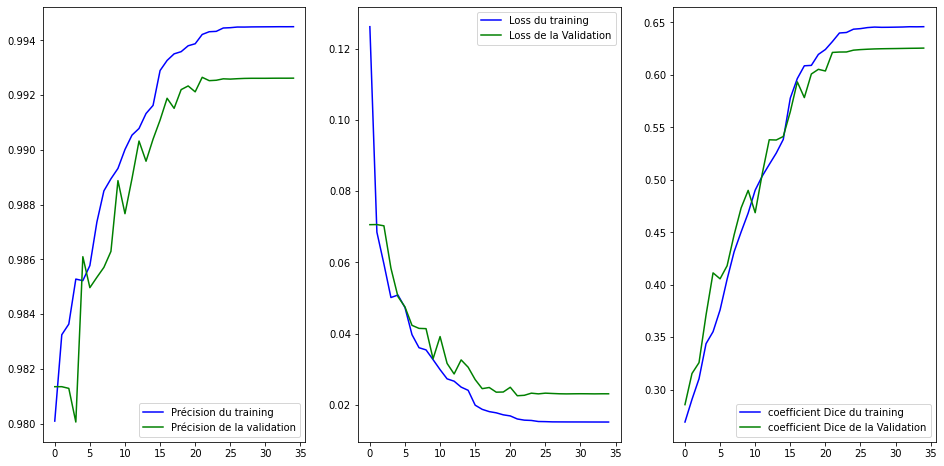

In [ ]:
#Chargement du modèle avec des fonctions personnalisées pour le calcul de performance
model = keras.models.load_model('/content/drive/MyDrive/model.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef": dice_coef
                                                   "dice_necrotic": dice_coef_necrotic,
                                                   "dice_oedeme": dice_coef_edema,
                                                   "dice_evolutif": dice_evolutif                                              }, compile=False)
scores = pd.read_csv('/content/drive/MyDrive/scores.log', sep=',', engine='python')


accuracy=scores['accuracy']
val_acc=scores['val_accuracy']
loss=scores['loss']
val_loss=scores['val_loss']
train_dice=scores['dice_coef']
val_dice=scores['val_dice_coef']

epoch=range(35)
f,ax=plt.subplots(1,3,figsize=(16,8))

ax[0].plot(epoch,accuracy,'b',label='Précision du training')
ax[0].plot(epoch,val_acc,'g',label='Précision de la validation')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Loss du training')
ax[1].plot(epoch,val_loss,'g',label='Loss de la Validation')
ax[1].legend()

#Utilisé pour les tâches de segmentation
ax[2].plot(epoch,train_dice,'b',label='coefficient Dice du training')
ax[2].plot(epoch,val_dice,'g',label='coefficient Dice de la Validation')
ax[2].legend()

plt.show()

In [ ]:
import random

def pathPredictions(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOL_SLICES, IMG_SIZE, IMG_SIZE, 2))
    y = np.empty((VOL_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'BraTS2021_00{case}_flair.nii.gz');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS2021_00{case}_t1ce.nii.gz');
    ce=nib.load(vol_path).get_fdata() 
    
    vol_path = os.path.join(case_path, f'BraTS2021_00{case}_seg.nii.gz');
    seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOL_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOL_START], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOL_START], (IMG_SIZE,IMG_SIZE))
        y[j,:,:] = cv2.resize(seg[:,:,j+VOL_START], (IMG_SIZE,IMG_SIZE))
    
    return model.predict(X/np.max(X), verbose=1)

In [ ]:
def AxialDisplayPredictions(case, start_slice = 60):
    path = f"/content/drive/MyDrive/BRATS2021/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_00{case}"
    current_ex = nib.load(os.path.join(path, f'BraTS2021_00{case}_seg.nii.gz')).get_fdata()
    
    #flair mais aussi les autres si possible
    flairImage = nib.load(os.path.join(path, f'BraTS2021_00{case}_flair.nii.gz')).get_fdata()
    t1Image = nib.load(os.path.join(path, f'BraTS2021_00{case}_t1.nii.gz')).get_fdata()
    t2Image = nib.load(os.path.join(path, f'BraTS2021_00{case}_t2.nii.gz')).get_fdata()
    t1ceImage = nib.load(os.path.join(path, f'BraTS2021_00{case}_t1ce.nii.gz')).get_fdata()
    p = pathPredictions(path,case)

    core = p[:,:,:,1]
    edema = p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    print("Image FLAIR")
    for i in range(6): #Ajouter des background de cerveau derrière chaque image
      axarr[i].imshow(cv2.resize(flairImage[:,:,start_slice+VOL_START], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(flairImage[:,:,start_slice+VOL_START], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Image FLAIR')
    current=cv2.resize(current_ex[:,:,start_slice+VOL_START], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(current, cmap="Reds", interpolation='none', alpha=0.3) 
    axarr[1].title.set_text('Vérité Terain')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('Toutes les classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} prévision')
    axarr[4].imshow(core[start_slice,:,], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} prévision')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} prévision')
    plt.show()
      #ax1.imshow(rotate(montage(image_flair[50:-50,:,:]), 90, resize=True), cmap ='gray')

4/4 [==============================] - 13s 3s/step
Image FLAIR


<Figure size 1296x3600 with 0 Axes>

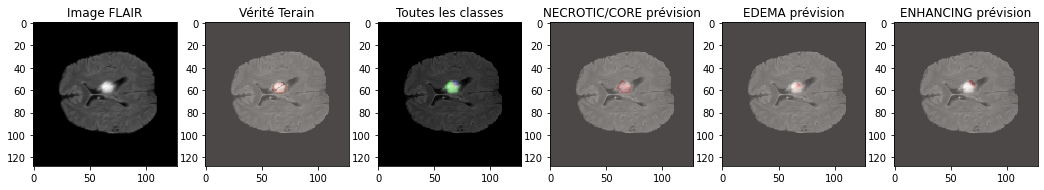

4/4 [==============================] - 13s 3s/step
Image FLAIR


<Figure size 1296x3600 with 0 Axes>

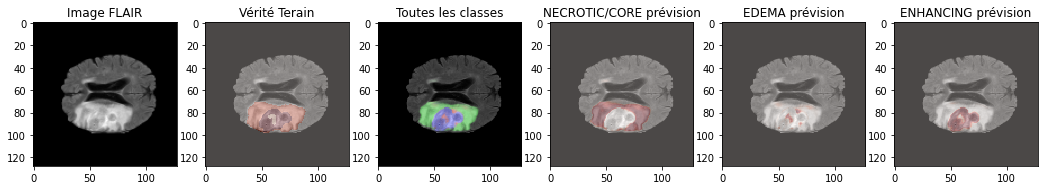

4/4 [==============================] - 13s 3s/step
Image FLAIR


<Figure size 1296x3600 with 0 Axes>

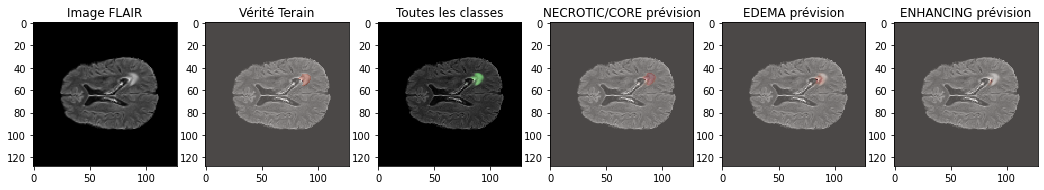

4/4 [==============================] - 13s 3s/step
Image FLAIR


<Figure size 1296x3600 with 0 Axes>

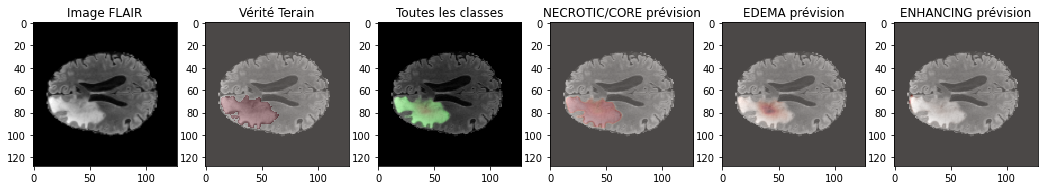

In [ ]:
#chiffre au hasard pour choisir les images au lieu de ID  
AxialDisplayPredictions(case=test_ids[0][-3:])
AxialDisplayPredictions(case=test_ids[1][-3:])
AxialDisplayPredictions(case=test_ids[2][-3:])
AxialDisplayPredictions(case=test_ids[3][-3:])

#autres angles de vue
#SagittalDisplayPredictions(case=test_ids[random.randint(0,30)][-3:])
#CoronalDisplayPredictions(case=test_ids[random.randint(0,30)][-3:])

In [ ]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.000001, verbose=1),
        csv_logger
    ]

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_evolutif] )
print("Evaluation des données de test")
#results = model.evaluate(test_data, batch_size=100, callbacks= callbacks)
print(" Loss,                 Accuracy,            coefficient DICE,  précision,      sensibilité,      spécificité,          coef dice necrotic,                 coef dice oedème,             coef dice enhancing :\n", results)

Evaluation des données de test
 Loss,                 Accuracy,            coefficient DICE,  précision,      sensibilité,      spécificité,          coef dice necrotic,                 coef dice oedème,             coef dice enhancing :
 [0.02218567579984665, 0.9934776425361633, 0.824736475944519, 0.6347616314888, 0.9937870502471924, 0.9921641945838928, 0.997901439666748, 0.6170417070388794, 0.7414198517799377, 0.7148681282997131]
